## Домашнее задание к вебинару №4

что надо сделать 
1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup 
import time
from urllib.parse import urlparse, urljoin
from tqdm.notebook import tqdm

Ограничился 500 запросами, большее количество Роскомнадзор банит. На BS подбирать параметры бесполезно. На Scrapy легко бы проблему победил.

In [5]:
## найти id каждого вопроса на страницах
page = 1
main_url = 'https://zpp.rospotrebnadzor.ru/Forum/Appeals/AjaxindexList?page={page}&searchtext=&categories=[]'

def ids_from_page(soup):
    return [i.get('href') for i  in soup.findAll('a', {'class':'appeal-title-link'})]
    
urls = []
for page in tqdm(range(1, 500), desc='Pages'):
    time.sleep(0.5)
    res = requests.get(main_url.format(page=page))  
    soup = BeautifulSoup(res.text)
    urls.extend(ids_from_page(soup))

Pages:   0%|          | 0/499 [00:00<?, ?it/s]

In [6]:
## имея id запросов достанем тексты на страницах
domain = 'https://zpp.rospotrebnadzor.ru'

def get_text_page_question(soup):
    return soup.findAll('p', {'class':'appeal-details-message'})[0].text
def get_text_page_answer(soup):
    return soup.findAll('p', {'class':'appeal-comments-message'})[0].text

question = []
answers = []

for url in tqdm(urls, desc='Pages'):
    time.sleep(0.5)
    res = requests.get(urljoin(domain, url))  
    soup = BeautifulSoup(res.text)
    
    question.append(get_text_page_question(soup))
    try:
        answers.append(get_text_page_answer(soup))
    except:
        answers.append('No answer')

Pages:   0%|          | 0/2495 [00:00<?, ?it/s]

ConnectionError: HTTPSConnectionPool(host='zpp.rospotrebnadzor.ru', port=443): Max retries exceeded with url: /Forum/Appeals/Details/30570 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fa42a09e670>: Failed to establish a new connection: [Errno 113] No route to host'))

In [ ]:
## посмотрим, что скачалось
N = 2
print('Q:', question[N])
print()
print('A:', answers[N])

In [7]:
type(question)

list

In [8]:

df = pd.DataFrame(question, columns=["questions"])
df.to_csv('questions.csv', index=False)

In [8]:
df = pd.read_csv('questions.csv')

In [10]:
df.shape

(1927, 1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1927 entries, 0 to 1926
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   questions  1927 non-null   object
dtypes: object(1)
memory usage: 15.2+ KB


# ПРЕДОБРАБОТКА

In [2]:
import re
import numpy as np
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from multiprocessing import Pool
from pymystem3 import Mystem

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/fn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
! pip install pymorphy2

You should consider upgrading via the '/home/fn/anaconda3/bin/python -m pip install --upgrade pip' command.


In [5]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [6]:
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')

# mystem = Mystem()
# def lemmatize(words, lemmer = mystem, stopwords = stopwords_list):
#     lemmas = lemmer.lemmatize(' '.join(words))
#     return [w for w in lemmas if not w in stopwords 
#             and w.isalpha()]

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

In [9]:
df.questions.iloc[1]

'Здравствуйте, ребенок находится в ДОЛ ,в Кировской области, сказали что без QR кода ,которому менее полугода, посещение невозможно,так ли это??'

In [10]:
print(preprocess(df.questions.iloc[1]))

['здравствуйте', 'ребёнок', 'находиться', 'дол', 'кировский', 'область', 'сказать', 'код', 'который', 'менее', 'полгода', 'посещение', 'невозможно', 'это']


In [19]:
preprocessed_text = list(tqdm(map(preprocess, df['questions']), total=len(df)))

  0%|          | 0/1927 [00:00<?, ?it/s]

In [20]:
df['questions'] = preprocessed_text

In [21]:
df.sample(3)

,questions
1015,"[добрый, день, вернуться, египет, сдать, пцр, ..."
1191,"[магазин, dns, приобрести, мфу, покупка, неодн..."
509,"[добрый, день, являться, постоянный, покупател..."


# Модель LDA

In [11]:
!pip install -U gensim

You should consider upgrading via the '/home/fn/anaconda3/bin/python -m pip install --upgrade pip' command.


In [12]:
from gensim.models import *
from gensim import corpora

Модель использует векторное представление документов, например, мешок слов (bow), поэтому сперва создадим словарь:

In [24]:
dictionary = corpora.Dictionary(df['questions'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('rospotrebnadzor.dict')

Векторизуем документы:

In [25]:
corpus = [dictionary.doc2bow(text) for text in df['questions']]
corpora.MmCorpus.serialize('rospotrebnadzor.model', corpus) 

Теперь можем обучать модель:


In [26]:
%time 

lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50,\
                        update_every=1, passes=2)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 15 µs


In [27]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(7,
  '0.043*"компания" + 0.030*"сотрудник" + 0.028*"номер" + 0.027*"сообщить" + 0.026*"получить" + 0.025*"ответ" + 0.024*"рубль" + 0.022*"информация" + 0.019*"предоставить" + 0.018*"никакой"'),
 (18,
  '0.077*"ремонт" + 0.041*"документ" + 0.033*"иметь" + 0.033*"основание" + 0.032*"официальный" + 0.031*"пожалуйста" + 0.030*"заключение" + 0.028*"акт" + 0.027*"гарантийный" + 0.027*"деятельность"'),
 (11,
  '0.063*"договор" + 0.061*"ребёнок" + 0.053*"услуга" + 0.034*"декабрь" + 0.031*"связь" + 0.031*"год" + 0.025*"это" + 0.024*"детский" + 0.024*"который" + 0.024*"работа"'),
 (8,
  '0.058*"это" + 0.042*"результат" + 0.031*"человек" + 0.029*"находиться" + 0.028*"квартира" + 0.028*"код" + 0.028*"всё" + 0.027*"который" + 0.026*"здравствуйте" + 0.022*"очень"'),
 (6,
  '0.115*"вода" + 0.061*"спасибо" + 0.058*"коробка" + 0.054*"делать" + 0.037*"гарантия" + 0.037*"температура" + 0.036*"сутки" + 0.031*"ситуация" + 0.029*"предоплата" + 0.028*"упаковка"'),
 (2,
  '0.218*"оформление" + 0.161*"начать

На полученные темы можно посмотреть, изобразив их на плоскости с помощью библиотеки pyLDAvis. Чтобы спроецировать темы на плоскость, внутри применяется PCA-разложение.


In [28]:
!pip install pyLDAvis

You should consider upgrading via the '/home/fn/anaconda3/bin/python -m pip install --upgrade pip' command.


In [29]:
import pyLDAvis
#import pyLDAvis.gensim as gensimvis
import pyLDAvis.gensim_models as gensimvis

%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/home/fn/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


CPU times: user 1.53 s, sys: 160 ms, total: 1.69 s
Wall time: 7.07 s


Посмотрим на метрики качества получившейся модели: перплексию и среднюю когерентность:


In [30]:
print(lda.log_perplexity(corpus))

/home/fn/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-11.15932469410884


In [31]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

/home/fn/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Персплексия:  1.4240825515149744e-05


In [32]:
coherence_model_lda = CoherenceModel(model=lda, texts=df['questions'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

/home/fn/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Средняя когерентность:  0.3572773593234021


Теперь можно подобрать оптимальное количество тем, опираясь на значение метрик:


In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

/home/fn/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/fn/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/5 [00:00<?, ?it/s]

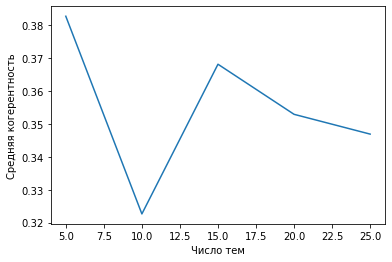

In [34]:
topics_list = [5, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=df['questions'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

Подробнее о метриках для оценки тематических моделей:

    Перплексия
    Когерентность: один пост, другой пост



На 10 кластерах пересечение кластеров наименьшее. Мелкий кластер поглощен полностью большим - можно их объединить.

In [35]:
lda_15 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=15, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_15, corpus, dictionary)
pyLDAvis.display(vis_data)

/home/fn/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/fn/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


Ну не плохое разделение.

In [36]:
lda_15.show_topics(num_topics=10, num_words=15, formatted=True)

/home/fn/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(3,
  '0.066*"проверка" + 0.056*"просить" + 0.055*"адрес" + 0.043*"работать" + 0.041*"принять" + 0.041*"мера" + 0.040*"полный" + 0.036*"провести" + 0.035*"жалоба" + 0.031*"выдать" + 0.028*"продукт" + 0.025*"отсутствовать" + 0.024*"документ" + 0.020*"продукция" + 0.017*"ценник"'),
 (2,
  '0.039*"это" + 0.019*"всё" + 0.019*"мочь" + 0.017*"день" + 0.016*"дать" + 0.015*"который" + 0.015*"вопрос" + 0.015*"здравствуйте" + 0.014*"сказать" + 0.014*"декабрь" + 0.013*"время" + 0.012*"результат" + 0.012*"ситуация" + 0.011*"работа" + 0.010*"хотеть"'),
 (5,
  '0.179*"телефон" + 0.101*"ремонт" + 0.100*"номер" + 0.053*"оператор" + 0.045*"заявка" + 0.041*"звонок" + 0.037*"мтс" + 0.036*"связь" + 0.029*"обещать" + 0.028*"дверь" + 0.026*"позвонить" + 0.025*"никакой" + 0.025*"звонить" + 0.023*"дозвониться" + 0.021*"день"'),
 (13,
  '0.066*"товар" + 0.062*"возврат" + 0.038*"магазин" + 0.032*"интернет" + 0.026*"чек" + 0.025*"потребитель" + 0.023*"право" + 0.022*"защита" + 0.020*"сайт" + 0.019*"отказаться" 

In [37]:
print(lda_15.log_perplexity(corpus))

/home/fn/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-9.204167727405633


In [38]:
print('Персплексия: ', np.exp(lda_15.log_perplexity(corpus)))

/home/fn/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Персплексия:  0.00010062178587535094


In [39]:
coherence_model_lda = CoherenceModel(model=lda, texts=df['questions'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

/home/fn/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Средняя когерентность:  0.3468870513503909
